# Lubby2 Finite

simple triaxial creep test -- comparison of small and finite strains.

In [9]:
import tfel.math
import mtest
import numpy as np
import matplotlib.pyplot as plt
import os
#plt.rcParams.update({'font.size': 16})
%run plot_settings.py
mtest.setVerboseMode(mtest.VerboseLevel.VERBOSE_QUIET)

In [10]:
GM0  = 9.54e3
KM0  = 2.78e4
GK0  = 6.27e4
mK   = -0.254
mvK  = -0.327
mvM  = -0.267
etaK0= 1.66e5
etaM0= 4.03e6

sc = -2
sdef = 20.

In [11]:
build_finite = 'mfront --obuild --interface=generic Lubby2Finite.mfront'
build_small = 'mfront --obuild --interface=generic --debug Lubby2mod.mfront'
#os.system(build_finite)
#os.system(build_small)

In [12]:
def run_finite(t_discrete):
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(1)
    m.setBehaviour('generic', './src/libBehaviour.so', 'Lubby2Finite')
    #
    m.setExternalStateVariable("Temperature", 293.15)
    #
    m.setDeformationGradient([1,1,1,0,0,0,0,0,0])

    m.setStress([sc,sc,sc-sdef,0,0,0])
    m.setImposedDeformationGradient('FXZ', 0.0)
    m.setImposedDeformationGradient('FZX', 0.0)
    m.setImposedDeformationGradient('FYZ', 0.0)
    m.setImposedDeformationGradient('FZY', 0.0)
    m.setImposedDeformationGradient('FYX', 0.0)
    m.setImposedDeformationGradient('FXY', 0.0)
    m.setImposedStress('SXX', sc)
    m.setImposedStress('SYY', sc)
    m.setImposedStress('SZZ', sc-sdef)
    
    #
    m.setMaterialProperty('YoungModulus', (9 * GM0 * KM0) / (3 * KM0 + GM0))
    m.setMaterialProperty('PoissonRatio', (3 * KM0 - 2 * GM0) / (2 * GM0 + 6 * KM0))
    m.setMaterialProperty('KelvinShearModulus', GK0)
    m.setMaterialProperty('KelvinViscosity', etaK0)
    m.setMaterialProperty('MaxwellViscosity', etaM0)
    m.setMaterialProperty('KelvinElasticParameter', mK)
    m.setMaterialProperty('MaxwellViscoParameter', mvM)
    m.setMaterialProperty('KelvinViscoParameter', mvK)

    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = {'time': [0], 'strain': [s.e1], 'stress': [s.s1]}
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical['time'].append(t_discrete[i+1])
        numerical['strain'].append(s.e1)
        numerical['stress'].append(s.s1)
    return numerical

In [13]:
def run_small(t_discrete):
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(1)
    m.setBehaviour('generic', './src/libBehaviour.so', 'Lubby2mod')
    #
    m.setExternalStateVariable("Temperature", 293.15)
    #

    m.setStress([sc,sc,sc-sdef,0,0,0])
    m.setImposedStrain('EXZ', 0.0)
    m.setImposedStrain('EYZ', 0.0)
    m.setImposedStrain('EXY', 0.0)
    m.setImposedStress('SXX', sc)
    m.setImposedStress('SYY', sc)
    m.setImposedStress('SZZ', sc-sdef)
    #
    m.setMaterialProperty('YoungModulus', (9 * GM0 * KM0) / (3 * KM0 + GM0))
    m.setMaterialProperty('PoissonRatio', (3 * KM0 - 2 * GM0) / (2 * GM0 + 6 * KM0))
    m.setMaterialProperty('KelvinShearModulus', GK0)
    m.setMaterialProperty('KelvinViscosity', etaK0)
    m.setMaterialProperty('MaxwellViscosity', etaM0)
    m.setMaterialProperty('KelvinElasticParameter', mK)
    m.setMaterialProperty('MaxwellViscoParameter', mvM)
    m.setMaterialProperty('KelvinViscoParameter', mvK)

    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = {'time': [0], 'strain': [s.e1], 'stress': [s.s1]}
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical['time'].append(t_discrete[i+1])
        numerical['strain'].append(s.e1)
        numerical['stress'].append(s.s1)
    return numerical

In [14]:
times = np.append(0.01,np.append(np.linspace(0.02,10,20),np.linspace(11,1000,40)))

In [15]:
finite = run_finite(times)

In [16]:
small = run_small(times)

Plotting engineering strain in the following. Dashed are the small-strain results, solid the finite strain ones.

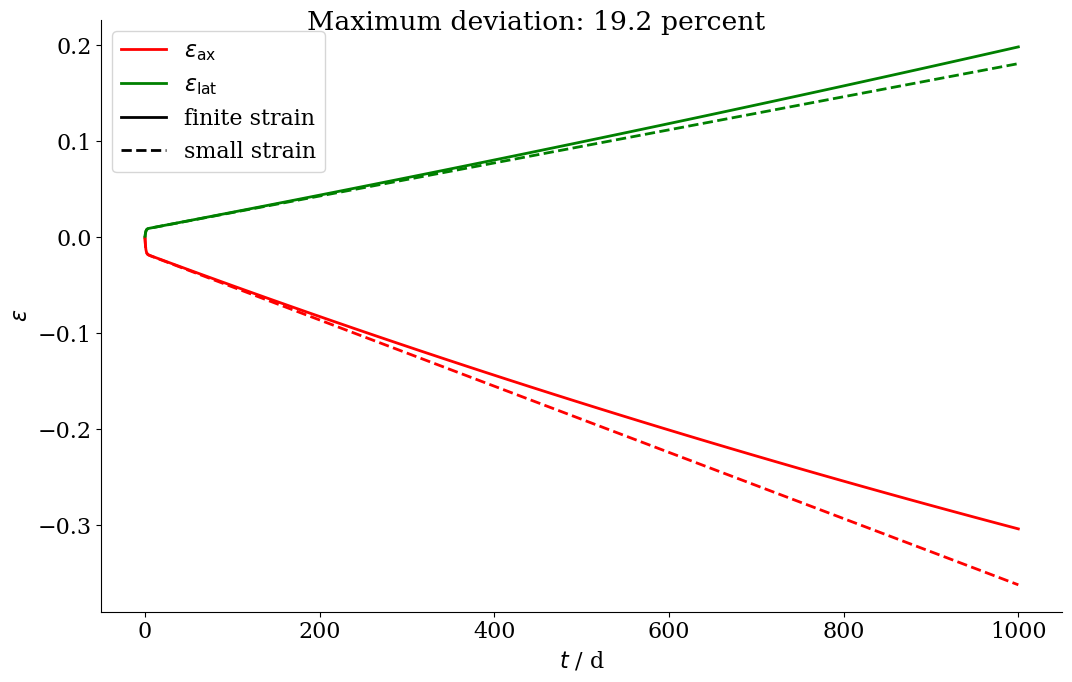

In [17]:
fig,ax = plt.subplots(figsize=(11,7))
ax.plot(finite['time'][1:],np.array(finite['strain'])[1:].T[2]-1,label='$\\epsilon_\\mathrm{ax}$',color='red')
ax.plot(finite['time'][1:],np.array(finite['strain'])[1:].T[0]-1,label='$\\epsilon_\\mathrm{lat}$',color='green')
ax.plot(small['time'][1:],np.array(small['strain'])[1:].T[2],ls='--',color='red')
ax.plot(small['time'][1:],np.array(small['strain'])[1:].T[0],ls='--',color='green')
ax.plot(0,0,ls='-',color='black',label='finite strain')
ax.plot(0,0,ls='--',color='black',label='small strain')
ax.set_xlabel('$t$ / d')
ax.set_ylabel('$\\epsilon$')
fig.tight_layout();
ax.legend();
fig.suptitle('Maximum deviation: %.1f percent' 
             %(np.abs((np.array(small['strain'])[-1].T[2]-np.array(finite['strain'])[-1].T[2]+1)/
               (np.array(finite['strain'])[-1].T[2]-1)) * 100));
fig.savefig('Lubby2Finite.pdf')

In [212]:
def run_finite_ss(t_discrete,ps=False,gmax=0.3):
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(1)
    m.setBehaviour('generic', './src/libBehaviour.so', 'Lubby2Finite')
    #
    m.setExternalStateVariable("Temperature", 293.15)
    #
    m.setDeformationGradient([1,1,1,0,0,0,0,0,0])

    m.setStress([sc,sc,sc,0,0,0])
    m.setImposedDeformationGradient('FXZ', 0.0)
    m.setImposedDeformationGradient('FZX', 0.0)
    m.setImposedDeformationGradient('FYZ', 0.0)
    m.setImposedDeformationGradient('FZY', 0.0)
    if (ps):
        m.setImposedDeformationGradient('FYX', {0:0, 150:gmax/2, 250: gmax/2})
        m.setImposedDeformationGradient('FXY', {0:0, 150:gmax/2, 250: gmax/2})
    else:
        m.setImposedDeformationGradient('FYX', 0.0)
        m.setImposedDeformationGradient('FXY', {0:0, 150:gmax, 250:gmax})
    m.setImposedDeformationGradient('FXX', 1.0)
    m.setImposedDeformationGradient('FYY', 1.0)
    m.setImposedDeformationGradient('FZZ', 1.0)
    
    #
    m.setMaterialProperty('YoungModulus', (9 * GM0 * KM0) / (3 * KM0 + GM0))
    m.setMaterialProperty('PoissonRatio', (3 * KM0 - 2 * GM0) / (2 * GM0 + 6 * KM0))
    m.setMaterialProperty('KelvinShearModulus', GK0)
    m.setMaterialProperty('KelvinViscosity', etaK0)
    m.setMaterialProperty('MaxwellViscosity', etaM0)
    m.setMaterialProperty('KelvinElasticParameter', mK)
    m.setMaterialProperty('MaxwellViscoParameter', mvM)
    m.setMaterialProperty('KelvinViscoParameter', mvK)

    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = {'time': [0], 'strain': [s.e1], 'stress': [s.s1]}
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical['time'].append(t_discrete[i+1])
        numerical['strain'].append(s.e1)
        numerical['stress'].append(s.s1)
    return numerical

In [218]:
def run_small_ss(t_discrete,gmax=0.3):
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(1)
    m.setBehaviour('generic', './src/libBehaviour.so', 'Lubby2mod')
    #
    m.setExternalStateVariable("Temperature", 293.15)
    #

    m.setStress([sc,sc,sc,0,0,0])
    m.setImposedStrain('EXZ', 0.0)
    m.setImposedStrain('EYZ', 0.0)
    m.setImposedStrain('EXY', {0:0, 150: gmax/2*np.sqrt(2), 250:gmax/2*np.sqrt(2)})
    m.setImposedStrain('EXX', 0.0)
    m.setImposedStrain('EYY', 0.0)
    m.setImposedStrain('EZZ', 0.0)
    #
    m.setMaterialProperty('YoungModulus', (9 * GM0 * KM0) / (3 * KM0 + GM0))
    m.setMaterialProperty('PoissonRatio', (3 * KM0 - 2 * GM0) / (2 * GM0 + 6 * KM0))
    m.setMaterialProperty('KelvinShearModulus', GK0)
    m.setMaterialProperty('KelvinViscosity', etaK0)
    m.setMaterialProperty('MaxwellViscosity', etaM0)
    m.setMaterialProperty('KelvinElasticParameter', mK)
    m.setMaterialProperty('MaxwellViscoParameter', mvM)
    m.setMaterialProperty('KelvinViscoParameter', mvK)

    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = {'time': [0], 'strain': [s.e1], 'stress': [s.s1]}
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical['time'].append(t_discrete[i+1])
        numerical['strain'].append(s.e1)
        numerical['stress'].append(s.s1)
    return numerical

In [219]:
times = np.append(0.01,np.append(np.linspace(0.02,10,20),np.append(np.linspace(11,150,30),np.linspace(155,250,20))))

In [381]:
finite_ss = run_finite_ss(times,False,0.3)

In [382]:
finite_ps = run_finite_ss(times,True,0.3)

In [383]:
small_ss = run_small_ss(times,0.3)

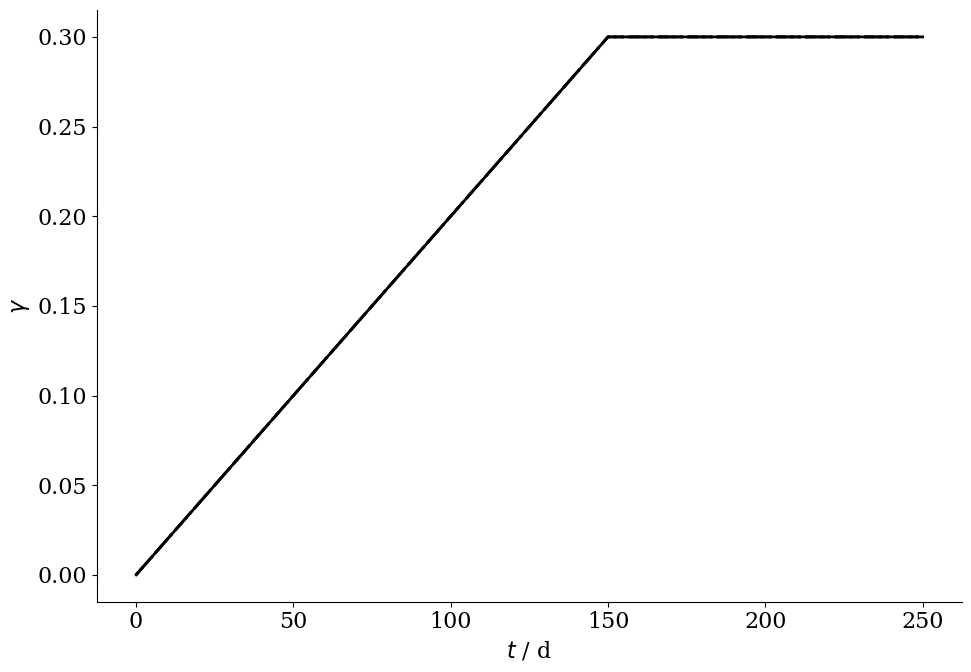

In [384]:
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(finite_ss['time'][1:],np.array(finite_ss['strain'])[1:].T[3]+np.array(finite_ss['strain'])[1:].T[4],label='simple shear',color='black')
ax.plot(finite_ps['time'][1:],np.array(finite_ps['strain'])[1:].T[3]+np.array(finite_ps['strain'])[1:].T[4],label='pure shear',color='black',ls='-.')
ax.plot(small_ss['time'][1:],np.array(small_ss['strain'])[1:].T[3]*2/np.sqrt(2),label='small strain',ls='--',color='black')
ax.set_xlabel('$t$ / d')
ax.set_ylabel('$\\gamma$')
fig.tight_layout();
#ax.legend();
fig.savefig('Lubby2Finite_shear.pdf')

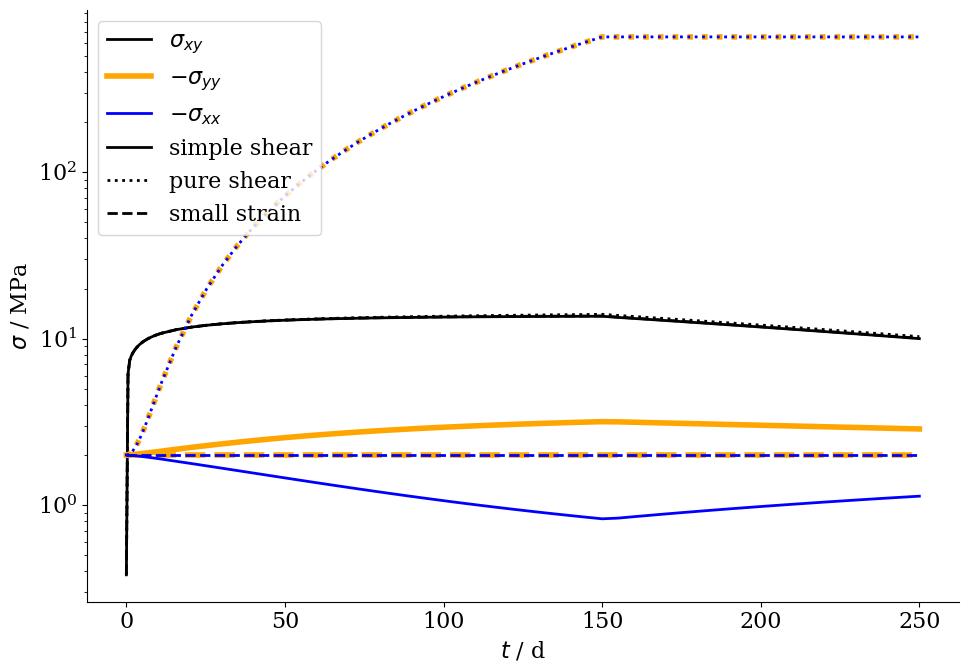

In [385]:
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(finite_ss['time'][1:],np.array(finite_ss['stress'])[1:].T[3]/np.sqrt(2),label='$\\sigma_{xy}$',color='black')
ax.plot(finite_ps['time'][1:],np.array(finite_ps['stress'])[1:].T[3]/np.sqrt(2),color='black',ls=':')
ax.plot(small_ss['time'][1:],np.array(small_ss['stress'])[1:].T[3]/np.sqrt(2),color='black',ls='--')
ax.plot(finite_ss['time'][1:],-np.array(finite_ss['stress'])[1:].T[1],label='$-\\sigma_{yy}$',color='orange',lw=4)
ax.plot(finite_ps['time'][1:],-np.array(finite_ps['stress'])[1:].T[1],color='orange',ls=':',lw=4)
ax.plot(small_ss['time'][1:],-np.array(small_ss['stress'])[1:].T[1],color='orange',ls='--',lw=4)
ax.plot(finite_ss['time'][1:],-np.array(finite_ss['stress'])[1:].T[0],label='$-\\sigma_{xx}$',color='blue')
ax.plot(finite_ps['time'][1:],-np.array(finite_ps['stress'])[1:].T[0],color='blue',ls=':')
ax.plot(small_ss['time'][1:],-np.array(small_ss['stress'])[1:].T[0],color='blue',ls='--')
ax.plot(0,0,color='black',ls='-',label='simple shear')
ax.plot(0,0,color='black',ls=':',label='pure shear')
ax.plot(0,0,color='black',ls='--',label='small strain')
ax.set_xlabel('$t$ / d')
ax.set_ylabel('$\\sigma$ / MPa')
fig.tight_layout();
ax.legend();
ax.set_yscale('log')
fig.savefig('Lubby2Finite_shear_stresses.pdf')

In [209]:
import sympy as sp
from sympy import init_printing
init_printing() 

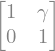

In [304]:
gamma = sp.symbols('gamma',positive=True,nonzero=True)
F1 = sp.Matrix([[1,gamma],[0,1]])
F1

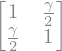

In [306]:
F2 = sp.Matrix([[1,gamma/2],[gamma/2,1]])
F2

In [29]:
E = lambda F: (F.T * F - sp.eye(2))/2

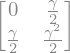

In [30]:
E(F1)

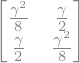

In [31]:
E(F2)

In [32]:
eps = lambda F: ((F - sp.eye(2)) + (F - sp.eye(2)).T)/2

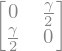

In [33]:
eps(F1)

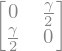

In [34]:
eps(F2)

In [35]:
C = lambda F: F.T * F

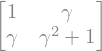

In [36]:
C(F1)

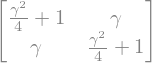

In [37]:
C(F2)

In [38]:
def Hencky(F):
    P, D = C(F).diagonalize()
    U = D.applyfunc(sp.sqrt)
    EH = (P * ((U + sp.ones(2) - sp.eye(2)).applyfunc(sp.log)) * P.inv())
    return EH, U, P

In [ ]:
EH1,U1d,P1=Hencky(F1)
EH1.simplify()
EH1

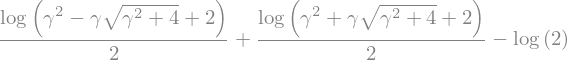

In [372]:
sp.trace(EH1).simplify()

In [ ]:
U1d.simplify()
U1d

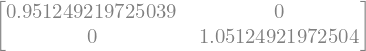

In [259]:
U1d.subs(gamma,0.1).evalf()

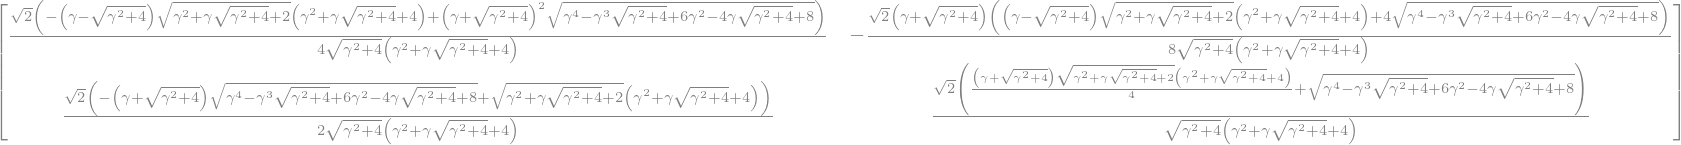

In [66]:
U1 = P1*U1d*P1.inv()
sp.simplify(U1)

In [ ]:
EH2,U2d,P2=Hencky(F2)
EH2.simplify()
EH2

In [371]:
sp.simplify(sp.trace(EH2)).subs(gamma,0.1)

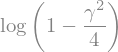

In [370]:
sp.log((4-gamma**2)/4)

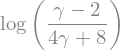

In [349]:
sp.log((gamma-2)/(4*(gamma+2)))

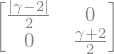

In [330]:
U2d.simplify()
U2d.applyfunc(sp.factor)

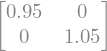

In [331]:
U2d.subs(gamma,0.1).evalf()

In [332]:
U2 = P2*U2d*P2.inv()

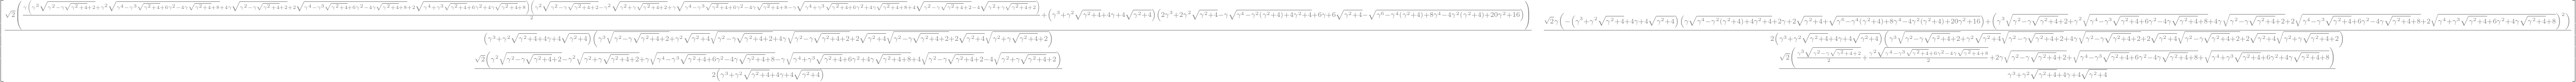

In [333]:
R1 = F1*U1.inv()
R1.simplify()
R1

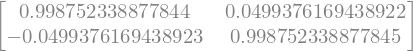

In [334]:
R1.subs(gamma,0.1).evalf()

In [ ]:
R2 = F2*U2.inv()
R2.simplify()
R2

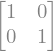

In [49]:
sp.simplify(R2.subs(sp.sqrt(gamma**4-8*gamma**2+16),4-gamma**2).subs(sp.sqrt(gamma**2-4*gamma+4),2-gamma).subs(sp.sqrt(gamma**2+4*gamma+4),2+gamma))

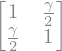

In [50]:
U2.subs(sp.sqrt(gamma**4-8*gamma**2+16),4-gamma**2).subs(sp.sqrt(gamma**2-4*gamma+4),2-gamma).subs(sp.sqrt(gamma**2+4*gamma+4),2+gamma)

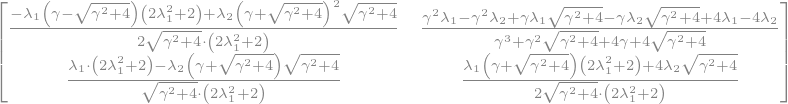

In [80]:
lambda1, lambda2 = sp.symbols('lambda_1 lambda_2', Positive=True)
U1m=U1.subs(sp.sqrt(2*gamma**2+2*gamma*sp.sqrt(gamma**2+4)+4),2*lambda1).subs(sp.sqrt(2*gamma**2-2*gamma*sp.sqrt(gamma**2+4)+4),2*lambda2)
U1n=sp.simplify(U1m).factor().subs(gamma**2+gamma*sp.sqrt(gamma**2+4)+4,2*lambda1**2+2).factor()
U1n

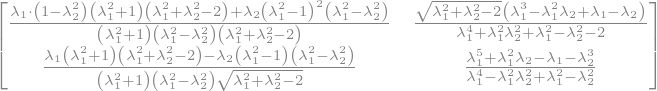

In [87]:
U1n.subs(sp.sqrt(gamma**2+4),(2*lambda1**2-2)/gamma-gamma).subs(gamma**2,lambda1**2+lambda2**2-2).applyfunc(sp.simplify)

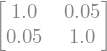

In [266]:
U2.subs(gamma,0.1)

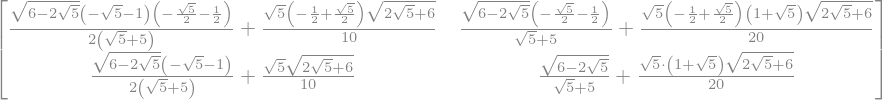

In [296]:
U1.subs(gamma,0.1)

In [301]:
rotation_angle = sp.atan2(R1[1, 0], R1[0, 0])
theta=rotation_angle.simplify()
theta_n=float(theta.subs(gamma,0.1).evalf())

In [302]:
print(theta_n, np.rad2deg(theta_n),"°")

-0.049958395721942835 -2.862405226111752 °


https://arxiv.org/pdf/1806.07749.pdf